In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

#from utils.utils import *
from utils.dataset import BloodCellDataset
from utils.configs import BloodCellConfig
import pandas as pd


from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import log
import random
import tqdm


import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
import os
import sys
import argparse
import json
from mrcnn import utils
import mrcnn.model as modellib
import keras
import tensorflow as tf
assert(tf.__version__ == "1.15.2")
assert(keras.__version__ == "2.2.4")

In [16]:
# Define working directory
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "maskrcnn-master","logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "maskrcnn-master", "mask_rcnn_coco.h5")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "BCCD_Dataset/BCCD")

if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

IMAGE_COLLECTION_PATH = r'../image_collection_blood_cells.json'
MODEL_BRANCH = "bloodcell20201214T2126"
CHECKPOINT_EPOCH = 100

# 1. Fetch metadata, prepare dataset for evaluation

In [17]:
# Load train/val split
with open(IMAGE_COLLECTION_PATH, 'r') as outfile:
    dataset = json.load(outfile)
dataset_train = dataset["train"]
dataset_val = dataset["val"]

# 2. Reload trained model

In [18]:
dataset_val = BloodCellDataset(IMAGE_DIR, dataset_val)
dataset_val.load_kernel()

100%|██████████| 64/64 [00:00<00:00, 88.83it/s]


In [19]:
config = BloodCellConfig()
config.IMAGE_RESIZE_MODE = "pad64"
config.IMAGE_SHAPE = [640,640,3]

In [20]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=config,
                          model_dir=MODEL_DIR)
model_path = os.path.join(MODEL_DIR, MODEL_BRANCH,
                          f"mask_rcnn_bloodcell_{CHECKPOINT_EPOCH:04d}.h5")
model.load_weights(model_path, by_name=True)

Re-starting from epoch 100


# 3.Evaluate single sample

## 3.1. Visualization

original_image           shape: (1024, 1408, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1408.00000  float64
gt_class_id              shape: (12,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (12, 4)               min:   36.00000  max: 1386.00000  int32
gt_mask                  shape: (1024, 1408, 12)      min:    0.00000  max:  127.00000  uint8


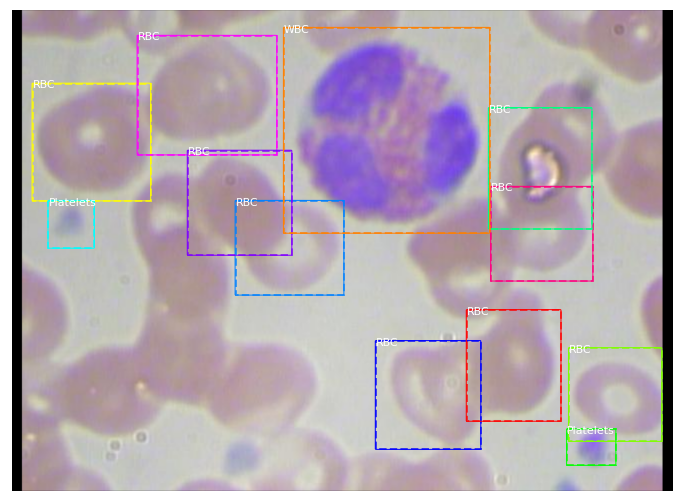

In [71]:
dataset_inference = dataset_val
# Test on a random image
image_id = random.choice(dataset_inference.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_inference, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_inference.class_names_preset, figsize=(12, 12))

Processing 1 images
image                    shape: (1024, 1408, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1408, 3)    min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 360096, 4)        min:   -0.08847  max:    1.02591  float32


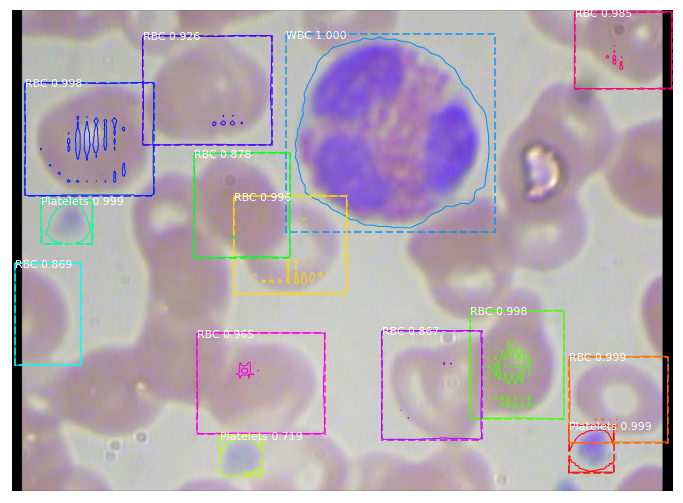

In [74]:
results = model.detect([original_image], verbose=1)
# r['scores']
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_inference.class_names_preset, r['scores'], figsize=(12, 12), show_mask=False)

## 3.2. Single Sample AP50/AP75

In [23]:
AP50, precisions50, recalls50, overlaps50 =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'], 0.5)
AP75, precisions75, recalls75, overlaps75 =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'], 0.75)

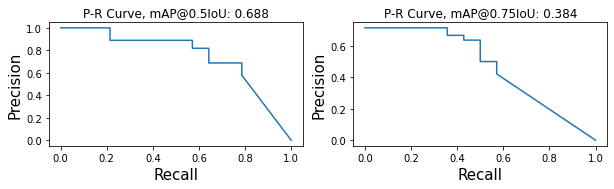

In [24]:
fig = plt.figure(figsize=(10,5))

plt.subplot(221)
plt.plot(recalls50, precisions50)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.title(f"P-R Curve, mAP@0.5IoU: {round(AP50,3)}")

plt.subplot(222)
plt.plot(recalls75, precisions75)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.title(f"P-R Curve, mAP@0.75IoU: {round(AP75,3)}")
plt.show()

In [25]:
mAP5095 = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                                 r["rois"], r["class_ids"],
                                 r["scores"], r['masks'])

AP @0.50:	 0.688
AP @0.55:	 0.635
AP @0.60:	 0.635
AP @0.65:	 0.635
AP @0.70:	 0.481
AP @0.75:	 0.384
AP @0.80:	 0.127
AP @0.85:	 0.032
AP @0.90:	 0.008
AP @0.95:	 0.000
AP @0.50-0.95:	 0.362


## 3.3. Single Sample Match Matrix

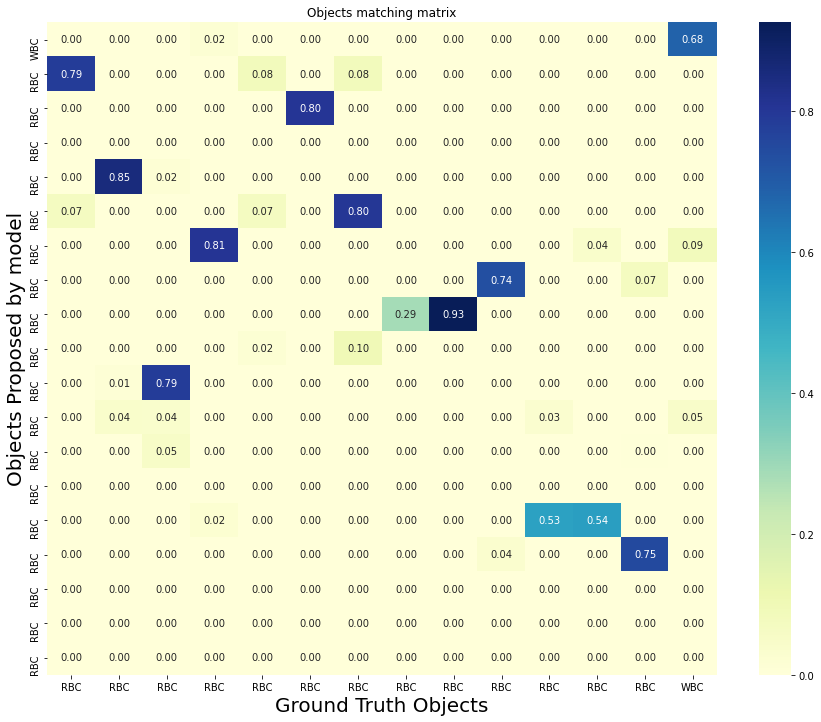

In [26]:
gt_class_names = [dataset_inference.class_names_preset[i] for i in gt_class_id]
pred_class_names = [dataset_inference.class_names_preset[i] for i in r["class_ids"]]

df_mm = pd.DataFrame(overlaps50, index=pred_class_names,
                 columns=gt_class_names)
plt.figure(figsize=(15, 12))
sn.heatmap(df_mm, annot=True, cmap="YlGnBu", fmt="2.2f")
plt.xlabel("Ground Truth Objects", fontsize=20)
plt.ylabel("Objects Proposed by model", fontsize=20)
plt.title("Objects matching matrix")
plt.show()

# 4. Evaluate dataset

## 4.1. P-R Curve

<font color='red'>Dismiss the indexing after dataset_inference.image_ids to evaluate model on full valid set.</font>

In [59]:
from utils.utils import get_object_matches, get_precision_recall, calculate_ap_from_pr, convert_bbox_to_masks
dataset_inference = dataset_val
IoU = 0.75

object_matches = []

for image_id in tqdm.tqdm(dataset_inference.image_ids):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_inference, config,
                               image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)
    r = results[0]
    # Use bbox rather than mask to calculate overlap/match
    gt_mask_bbox = convert_bbox_to_masks(gt_bbox, gt_mask.shape[:-1])
    pred_mask_bbox = convert_bbox_to_masks(r["rois"], r['masks'].shape[:-1])
    gt_matches, pred_matches, overlaps = utils.compute_matches(
        gt_bbox, gt_class_id, gt_mask_bbox, r["rois"],
        r["class_ids"], r["scores"], pred_mask_bbox, IoU)

    object_matches += get_object_matches(r, pred_matches, gt_matches, gt_class_id, image_id, overlaps)

100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


In [60]:
load_from_legacy_result = False
if load_from_legacy_result:
    df = pd.read_pickle(f'./evaluation_results_val_{CHECKPOINT_EPOCH}.pkl')
else:
    df = pd.DataFrame(object_matches)
    df.to_pickle(f'./evaluation_results_val_{CHECKPOINT_EPOCH}.pkl')

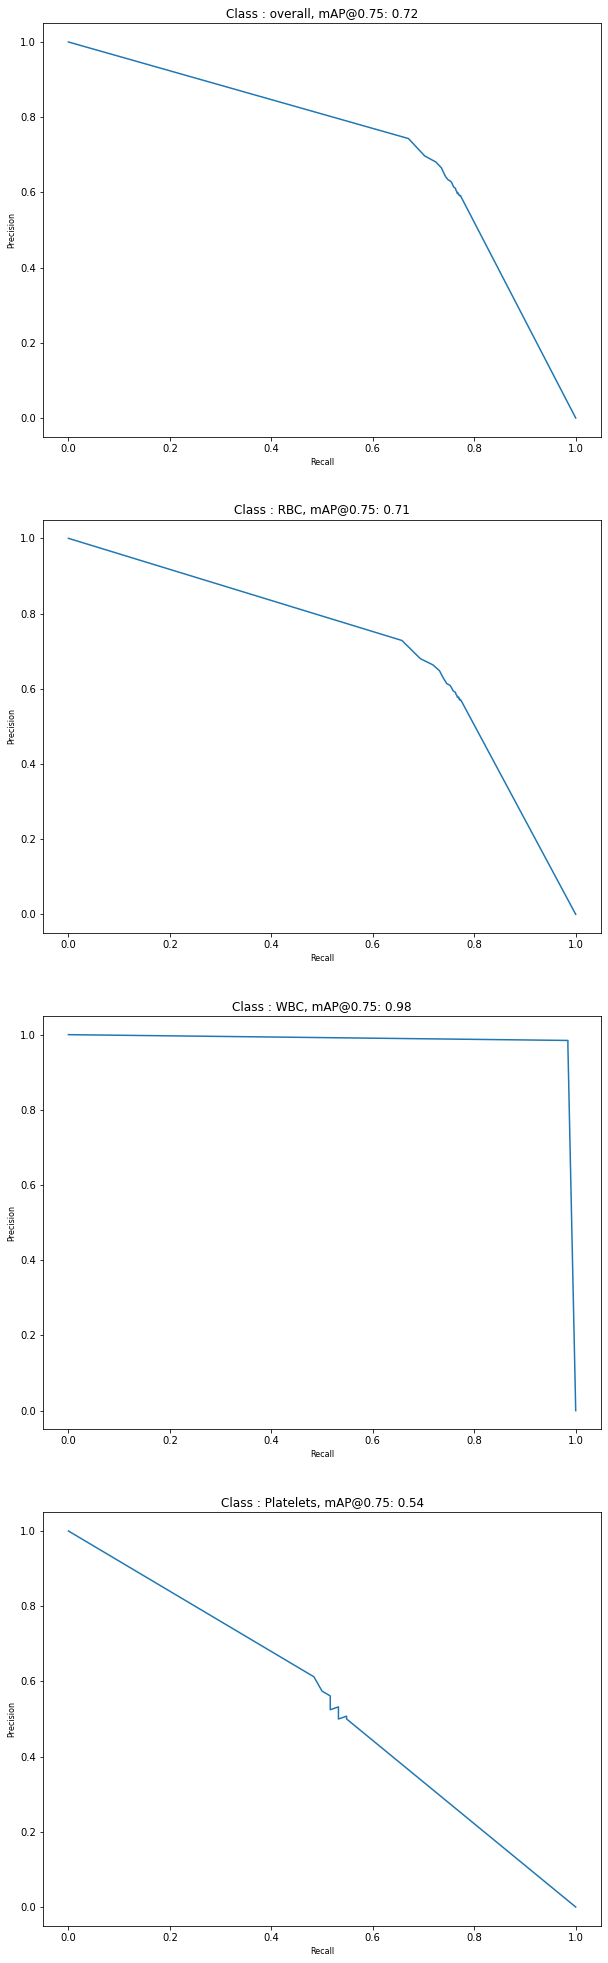

In [75]:
 _, axs = plt.subplots(4, 1, figsize=(10, 35))
mAPs = np.zeros((4, 1))
for class_id in range(len(dataset_inference.class_names_preset)):
    if class_id == 0:
        df_class = df
        class_name = "overall"
    else:
        df_class = df[(df.pred_class == class_id)|(df.gt_class == class_id)]
        class_name = dataset_inference.class_names_preset[class_id]

    precisions, recalls = get_precision_recall(df_class)
    mAP = calculate_ap_from_pr(precisions, recalls)

    axs[class_id].plot(recalls, precisions)
    axs[class_id].set_xlabel("Recall", fontsize=8)
    axs[class_id].set_ylabel("Precision", fontsize=8)
    axs[class_id].set_title(f"Class : {class_name}, mAP@0.75: {mAP:.2f}", fontsize=12)